In [133]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4, S0], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
# 
# T = BigFloat;
# setprecision(T,128)

T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------/

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/DynamicS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

#Properties of this simulation:

# global const H = T(1);
# global const Om = T(4);
# global const tstar = 1;
global const beta = 0;


# tmax = 5/H + tstar;
tmax = 3;

global const GBd = 3.1415 * T(1/2500);
global const LBd = -T(1/2);
global const M = T(1.);

global const z_boundaries = [zero(T), T(0.1),T(0.25), T(0.4),T(0.52)]; #Boundaries of grid domains.
global const domain_sizes = [15, 15, 15, 15]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape


diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;

In [125]:


global domAH = 4;
global indAH = 12;

global zAH = grids[domAH][indAH];
display(zAH)


0.5069098889480818

In [126]:
using Serialization
readin = []

open("Data files/FlatInitialData.dat","r") do io
    push!(readin,deserialize(io));
end

init_params = readin[1][1];
init_params[ind_t] = 0;
init_params[ind_S1] = DS1f(init_params);
InitVar = readin[1][2];

In [127]:
DS1f(init_params)

2.2223136692205854

In [128]:
Var = copy(InitVar)

VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:500
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
    init_params[ind_S1] = DS1f(init_params);
end

InitVar = ComputeBulk(init_params, Var);

X = 2.6245491073972604

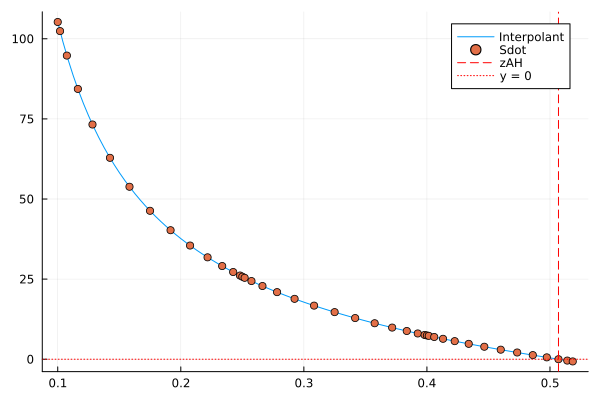

In [129]:
fig = PlotSdot(init_params,InitVar);
display(fig)

In [136]:
dt = T(.0000002);


outfile = [];
monitorfile = [];

FinalParams, VarFinal = Evolve(init_params,InitVar, 50, dt, 50, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◐ time = 0.008, constraint violation = 80826425.533,  Sdot at zAH = 184.244    Time: 0:01:17

LoadError: Data contains `Inf` or `NaN` values and a fit cannot be performed

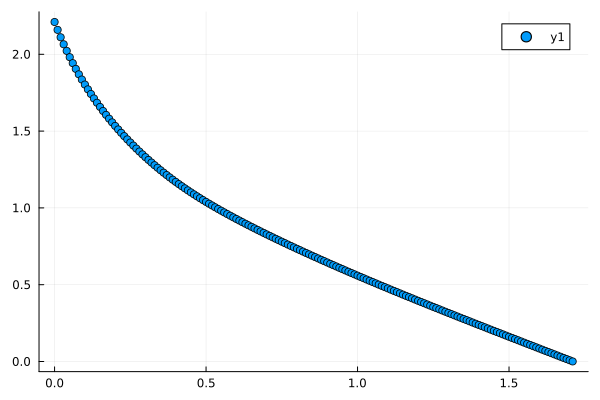

In [111]:
scatter([x[1] for x in monitorfile],[x[2][ind_S1] for x in monitorfile])

In [112]:
length(monitorfile)

172

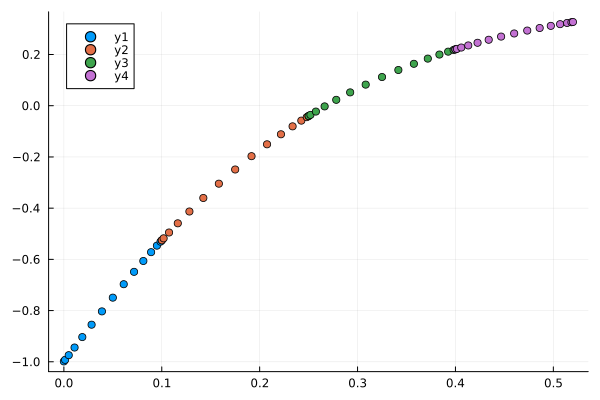

In [114]:
scatter(grids,outfile[170][1])

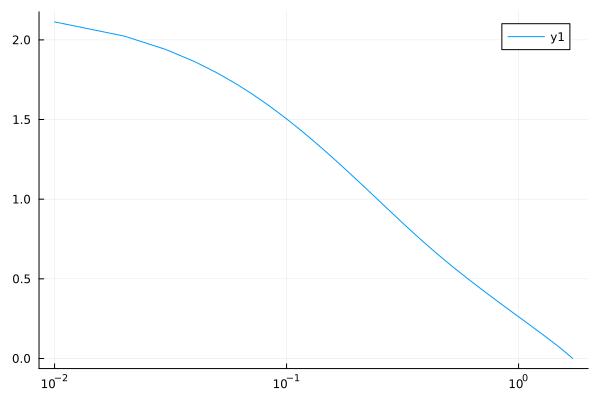

In [115]:
plot([x[1] for x in monitorfile[2:end]],[x[2][ind_S1]/x[2][ind_S0] for x in monitorfile[2:end]],xscale=:log10)

In [103]:
infP = monitorfile[end][4]

0.0050097548343977635

In [27]:
length(outfile)

51

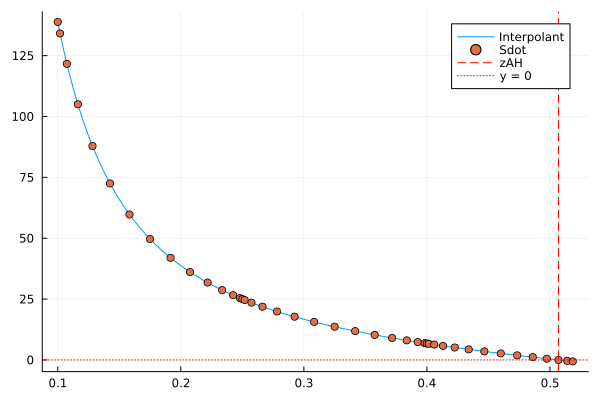

In [116]:
ind =170;
fig = PlotSdot(monitorfile[ind][2],outfile[ind]);
# title!(fig, string("time = ",format(monitorfile[ind][1],precision=2)))
display(fig)

In [ ]:
# using Serialization

# open("Data files/H2Run.dat","w") do io
#     serialize(io, [outfile, monitorfile]);
# end

In [ ]:
# using Serialization

# open("Data files/FlatInitialData.dat","w") do io
#     serialize(io, [FinalParams, VarFinal]);
# end

In [ ]:
function DS1_roots(params)

 t, X, p2, a4, DS0 = params;
co0 = ((-27*LBd)/(GBd*M^2) + 3*(-11*LBd + (54*a4)/M^2 - 14*M^2 + 72*beta*M^2 + (72*p2)/M - 72*X^2) + 2*GBd*(-189*a4 + 17*M^4 + 132*beta*M^4 - 60*M*p2 + 60*M^2*X^2))/48;
co1 = (27 + GBd*(9*LBd - 24*M^2) + GBd^2*(-54*a4 + 19*M^4 - 72*beta*M^4 - 72*M*p2 + 72*M^2*X^2))/(16*DS0^2*GBd*M^2);
co2 = (81*(-1 + GBd*M^2))/(32*DS0^4*M^2);
co3 = (27*GBd)/(32*DS0^6*M^2);

DS1eq = poly.Polynomial([co0,co1,co2,co3]);

candidates = poly.roots(DS1eq);

real_and_positive = [real(r) for r in candidates if (abs(imag(r))<1.e-8 && real(r)>0)]; 
sort!(real_and_positive);

return real_and_positive
end